In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
from numpy.linalg import matrix_rank
from scipy.linalg import null_space, inv
import random

In [2]:
data = loadmat('data/compEx2data.mat')
Xmodel = data['Xmodel']
x = data['x']
startind = data['startind']
endind = data['endind']

x1 = x[0][0]
x2 = x[0][1]

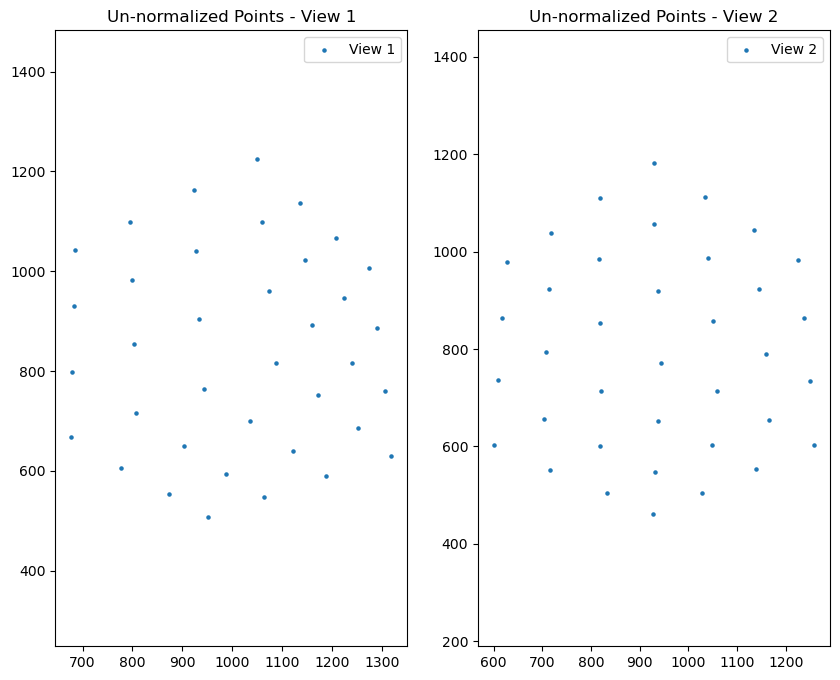

In [3]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.scatter(x1[0], x1[1], s=5, label="View 1")
plt.title("Un-normalized Points - View 1")
plt.axis('equal')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x2[0], x2[1], s=5, label="View 2")
plt.title("Un-normalized Points - View 2")
plt.axis('equal')
plt.legend()
plt.show()

In [4]:
def normalize_points(x,p=True):
    mean_x = np.mean(x[0])
    mean_y = np.mean(x[1])
    std_x = np.std(x[0])
    std_y = np.std(x[1])
    if p == True:
        print("Mean_x: ", mean_x)
        print("Mean_y: ", mean_y)
        print("Std_x: ", std_x)
        print("Std_y: ", std_y)
        print("###########################")
    
    N = np.array([[1/std_x, 0, -mean_x/std_x],
                  [0, 1/std_y, -mean_y/std_y],
                  [0, 0, 1]])
    x_normalized = N @ x
    return x_normalized, N

x1_normalized, N1= normalize_points(x1)
x2_normalized, N2 = normalize_points(x2)

Mean_x:  1014.8534437663469
Mean_y:  839.0382565664256
Std_x:  193.9348494348486
Std_y:  195.8207116811975
###########################
Mean_x:  930.9657367044463
Mean_y:  795.1859535591931
Std_x:  195.71450086643424
Std_y:  196.72253529302543
###########################


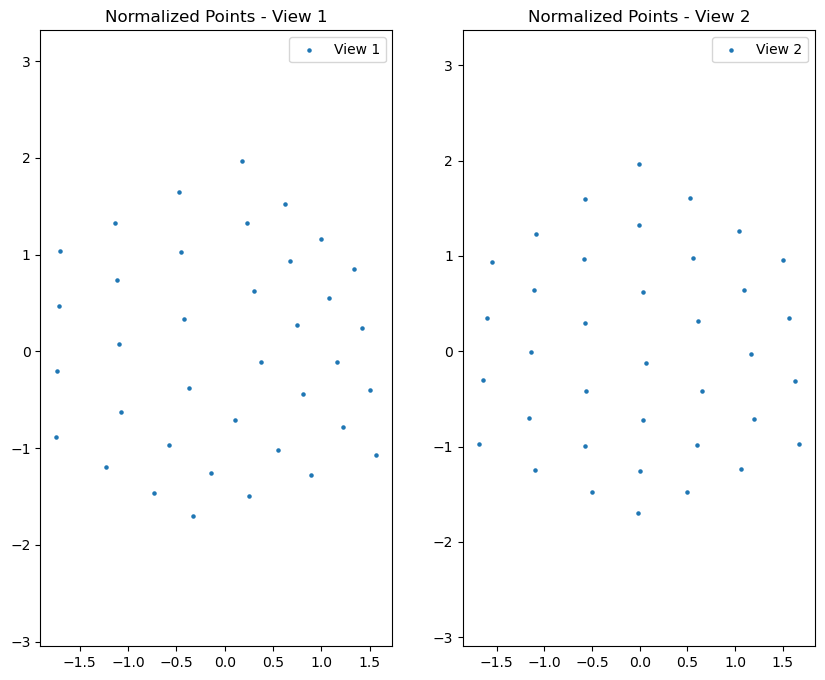

In [5]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.scatter(x1_normalized[0], x1_normalized[1], s=5, label="View 1")
plt.title("Normalized Points - View 1")
plt.axis('equal')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x2_normalized[0], x2_normalized[1], s=5, label="View 2")
plt.title("Normalized Points - View 2")
plt.axis('equal')
plt.legend()
plt.savefig('figs/CompEx2_1.png')
plt.show()

In [6]:
def estimate_camera_DLT(x_normalized, Xmodel):
    n_points = Xmodel.shape[1]
    M = []
    for i in range(n_points):
        X = Xmodel[:, i]
        x, y = x_normalized[0, i], x_normalized[1, i]
        M.append(np.array([
            [X[0], X[1], X[2], 1, 0, 0, 0, 0, -x*X[0], -x*X[1], -x*X[2], -x],
            [0, 0, 0, 0, X[0], X[1], X[2], 1, -y*X[0], -y*X[1], -y*X[2], -y]
        ]))

    M = np.vstack(M)

    # Solve using SVD
    U, S, Vt = np.linalg.svd(M)
    P = Vt[-1, :].reshape(3, 4) 
    return P, S[-1]

P1_normalized, sv1 = estimate_camera_DLT(x1_normalized, Xmodel)
P2_normalized, sv2 = estimate_camera_DLT(x2_normalized, Xmodel)
print(f"Smallest singular value (View 1): {sv1}")
print(f"Smallest singular value (View 2): {sv2}")

Smallest singular value (View 1): 0.05103414113484501
Smallest singular value (View 2): 0.04378218304600209


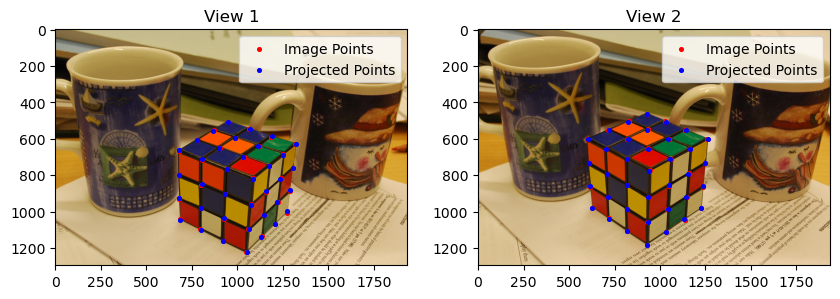

In [7]:
P1 = np.linalg.inv(N1) @ P1_normalized
P2 = np.linalg.inv(N2) @ P2_normalized

def pflat(x):
    return x / x[-1]
    
def project_points(P, X):
    X_homogenues = np.vstack((X, np.ones((1, X.shape[1]))))
    projected = pflat(P @ X_homogenues)
    return projected[:2]

# Project model points
projected_x1 = project_points(P1, Xmodel)
projected_x2 = project_points(P2, Xmodel)


image_file1 = "data/cube1.JPG"
image1 = plt.imread(image_file1)

image_file2 = "data/cube2.JPG"
image2 = plt.imread(image_file2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.scatter(x1[0], x1[1], color='red', s=7, label='Image Points')
plt.scatter(projected_x1[0], projected_x1[1],s=7, color='blue', label='Projected Points')
plt.title("View 1")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.scatter(x2[0], x2[1], color='red',s=7, label='Image Points')
plt.scatter(projected_x2[0], projected_x2[1],s=7, color='blue', label='Projected Points')
plt.title("View 2")
plt.savefig('figs/CompEx2_2.png')
plt.legend()

plt.show()


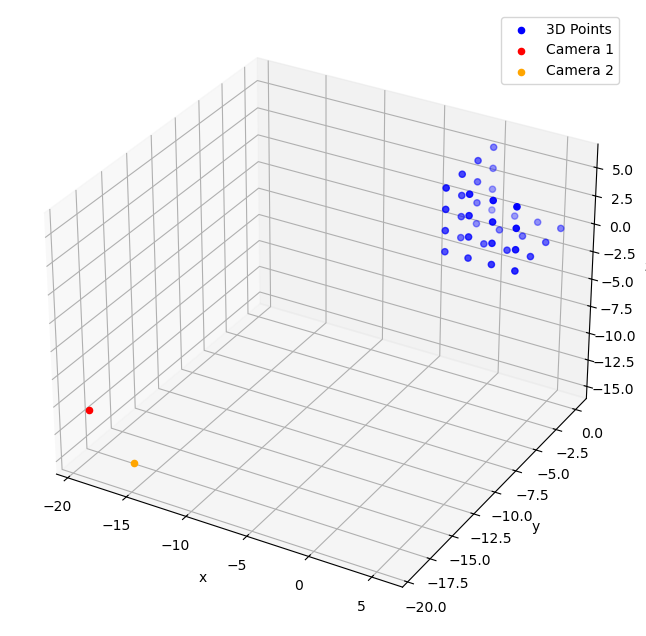

In [8]:
def plot_3d_points_and_cameras(Xmodel, P1, P2):
    
    def camera_center(P):
        return pflat(np.linalg.svd(P)[-1][-1])
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    c1 = camera_center(P1)
    c2 = camera_center(P2)
    
    ax.scatter(Xmodel[0], Xmodel[1], Xmodel[2], color="blue", label="3D Points")
    ax.scatter(c1[0], c1[1],c1[2], color='red', label="Camera 1")
    ax.scatter(c2[0],c2[1],c2[2], color='orange', label="Camera 2")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.show()

plot_3d_points_and_cameras(Xmodel, P1, P2)


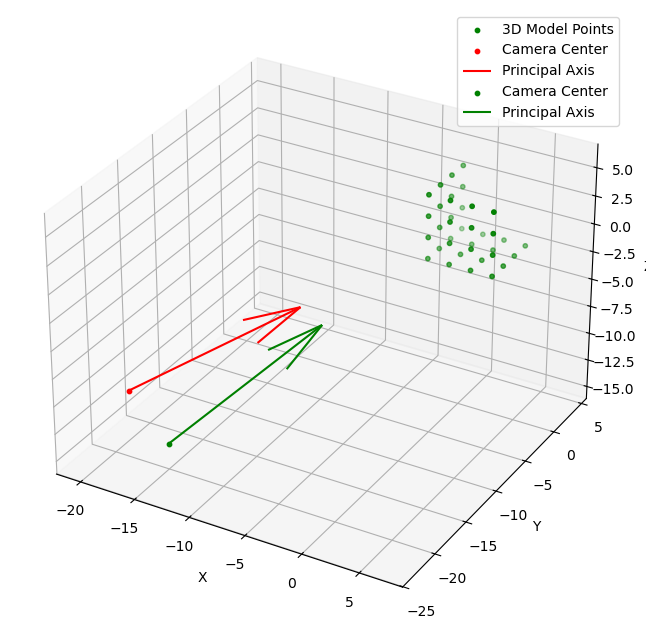

In [9]:
def plot_cams(P_list, ax):

    for P in P_list:
        c = null_space(P).flatten()
        c /= c[-1]
        v = P[2, :3]
        color = random.choice(["orange", "red", "green","blue"])
        ax.scatter(c[0], c[1], c[2], color=color, s=10, label="Camera Center")
        ax.quiver(c[0], c[1], c[2], v[0], v[1], v[2], color=color, length=1000, linewidth=1.5, label="Principal Axis")
        
def plot_3d_points_and_cameras_with_principal_axes(Xmodel, P_list):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(Xmodel[0], Xmodel[1], Xmodel[2], color='green', s=10, label="3D Model Points")
    plot_cams(P_list, ax)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.axis('equal')
    plt.savefig('figs/CompEx2_3.png')
    plt.show()

P_list = [P1, P2]
plot_3d_points_and_cameras_with_principal_axes(Xmodel, P_list)

In [10]:
def rq(a):
    m, n = a.shape
    eye_m = np.eye(m)
    
    p = eye_m[:, ::-1]
    
    q0, r0 = np.linalg.qr(np.dot(p, np.dot(a[:, :m].T, p)))
    
    r = np.dot(p, np.dot(r0.T, p))
    q = np.dot(p, np.dot(q0.T, p))
    
    fix = np.diag(np.sign(np.diag(r)))
    r = np.dot(r, fix)
    q = np.dot(fix, q)
    
    if n > m:
        q = np.hstack([q, np.linalg.inv(r) @ a[:, m:n]])
    
    return r, q

In [11]:
r1,q1 = rq(P1)
print(r1)

[[ 3.70325614e+01 -1.03610747e-01  1.49882525e+01]
 [ 0.00000000e+00  3.70050763e+01  1.06116532e+01]
 [ 0.00000000e+00  0.00000000e+00  1.52911082e-02]]


In [12]:
print(r1[-1][-1])

0.015291108194983525


In [13]:
r1 /= r1[-1][-1]
print(r1)

[[ 2.42183633e+03 -6.77588216e+00  9.80194001e+02]
 [ 0.00000000e+00  2.42003888e+03  6.93975417e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
r2,q2 = rq(P2)
print(r2)

[[ 3.70370202e+01 -1.69472422e-01  1.31724263e+01]
 [ 0.00000000e+00  3.72625328e+01  1.19354101e+01]
 [ 0.00000000e+00  0.00000000e+00  1.54915066e-02]]


In [15]:
r2 /= r2[-1][-1]
print(r2)

[[ 2.39079523e+03 -1.09396992e+01  8.50299885e+02]
 [ 0.00000000e+00  2.40535241e+03  7.70448632e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [16]:
np.savez("camera_matrices.npz", P1=P1, P2=P2, K1 = r1, K2=r2)

In [17]:
# Optional Part
def compute_rms_error(x_meas, x_proj):
    n = x_meas.shape[1]
    error = np.linalg.norm(x_meas - x_proj, 'fro') ** 2
    rms_error = np.sqrt(error / n)
    return rms_error

I = np.eye(3)

# Case 1: All points with normalization
P1_norm, _ = estimate_camera_DLT(x1_normalized, Xmodel)
P1_final_norm = np.linalg.inv(N1) @ P1_norm
projected_x1_norm = project_points(P1_final_norm, Xmodel)
rms_norm = compute_rms_error(x1[:2], projected_x1_norm)

# Case 2: All points without normalization
P1_no_norm, _ = estimate_camera_DLT(x1, Xmodel)
P1_final_no_norm = I @ P1_no_norm  # No normalization
projected_x1_no_norm = project_points(P1_final_no_norm, Xmodel)
rms_no_norm = compute_rms_error(x1[:2], projected_x1_no_norm)

# Subset of points
selected_indices = [0, 3, 12, 15, 24, 27, 30]
x1_subset = x1[:, selected_indices]
Xmodel_subset = Xmodel[:, selected_indices]

# Case 3: Subset of points with normalization
x1_subset_normalized, N1_subset = normalize_points(x1_subset,p=False)
P1_subset_norm, _ = estimate_camera_DLT(x1_subset_normalized, Xmodel_subset)
P1_final_subset_norm = np.linalg.inv(N1_subset) @ P1_subset_norm
projected_x1_subset_norm = project_points(P1_final_subset_norm, Xmodel)
rms_subset_norm = compute_rms_error(x1[:2], projected_x1_subset_norm)

# Case 4: Subset of points without normalization
P1_subset_no_norm, _ = estimate_camera_DLT(x1_subset, Xmodel_subset)
P1_final_subset_no_norm = I @ P1_subset_no_norm  # No normalization
projected_x1_subset_no_norm = project_points(P1_final_subset_no_norm, Xmodel)
rms_subset_no_norm = compute_rms_error(x1[:2], projected_x1_subset_no_norm)

print("RMS Errors:")
print(f"All points with normalization: {rms_norm:.4f}")
print(f"All points without normalization: {rms_no_norm:.4f}")
print(f"Subset of points with normalization: {rms_subset_norm:.4f}")
print(f"Subset of points without normalization: {rms_subset_no_norm:.4f}")


RMS Errors:
All points with normalization: 3.5712
All points without normalization: 3.5716
Subset of points with normalization: 4.1858
Subset of points without normalization: 4.1913
